# Expectation-maximization algorithm

We will derive and implement formulas for Gaussian Mixture Model — one of the most commonly used methods for performing soft clustering of the data. 

### Installation

We will need ```numpy```, ```scikit-learn```, ```matplotlib``` libraries for this 

In [259]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from grader import Grader
%matplotlib inline

In [260]:
grader = Grader()

## Implementing EM for GMM

For debugging we will use samples from gaussian mixture model with unknown mean, variance and priors. We also added inital values of parameters for grading purposes.

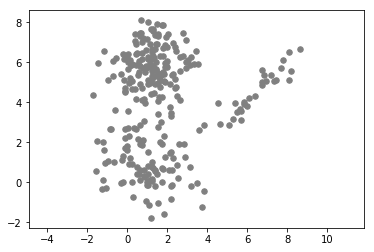

In [261]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

In [277]:
print(pi0.shape)
print(X.shape)
print(sigma0)
print(mu0)
type(X)

(3,)
(280, 2)
[[[ 1.00490413  1.89980228]
  [ 1.89980228  4.18354574]]

 [[ 1.96867815  0.78415336]
  [ 0.78415336  1.83319942]]

 [[ 0.19316335 -0.11648642]
  [-0.11648642  1.98395967]]]
[[-0.71336192  0.90635089]
 [ 0.76623673  0.82605407]
 [-1.32368279 -1.75244452]]


numpy.ndarray

### Reminder

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{P(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned. $T_i$ (cluster index for object $i$) is a binary vector with only one active bit in position corresponding to the true component. For example, if we have $C=3$ components and object $i$ lies in first component, $T_i = [1, 0, 0]$.

The joint distribution can be written as follows: $p(T, X \mid \theta) =  \prod\limits_{i=1}^N p(T_i, X_i \mid \theta) = \prod\limits_{i=1}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_i \mid \mu_c, \Sigma_c)]^{T_{ic}}$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q(T) = p(T|X, \theta)$. We will assume that $T_i$ (cluster index for object $i$) is a binary vector with only one '1' in position corresponding to the true component. To do so we need to compute $\gamma_{ic} = P(T_{ic} = 1 \mid X, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


<b>Important trick 1:</b> It is important to avoid numerical errors. At some point you will have to compute the formula of the following form: $\frac{e^{x_i}}{\sum_j e^{x_j}}$. When you compute exponents of large numbers, you get huge numerical errors (some numbers will simply become infinity). You can avoid this by dividing numerator and denominator by $e^{\max(x)}$: $\frac{e^{x_i-\max(x)}}{\sum_j e^{x_j - \max(x)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. This trick is called log-sum-exp. So, to compute desired formula you first subtract maximum value from each component in vector $X$ and then compute everything else as before.

<b>Important trick 2:</b> You will probably need to compute formula of the form $A^{-1}x$ at some point. You would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to solve the equation $Ay = x$. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by Gaussian elimination procedure. You can use ```np.linalg.solve``` for this.

<b>Other usefull functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

<b>Task 1:</b> Implement E-step for GMM using template below.

In [263]:
def calc_prob(X,mu,sigma, pi):
    """
    Calculates Gaussian probability of observing the given data under specified Distribution parameters, cluster - means and sd. 
    Input is:
    X: d, data points
    mu: d, means
    sigma: (d x d), covariance matrix
    pi: (1), weight 
    
    Returns:
    prob: (1), Gaussian probability of observing the given data under specified Distribution parameters
    """
    k = sigma.shape[0]
    #print(k)
    nr = np.exp(-0.5*(np.matmul((X-mu).T,np.linalg.solve(sigma,(X-mu)))))
    dr = np.sqrt(np.power(2*pi,k)*np.linalg.det(sigma))
    #print("Numerator: "+str(nr))
    #print("Denominator: "+str(dr))
    return nr/dr

In [264]:
calc_prob(X=np.array([0.5,0.5]),mu=np.array([0.5, 0.5]),sigma=np.array([[1,3/5], [3/5,1]]), pi=np.array(np.math.pi))

0.1989436788648692

In [282]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """    
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    ### YOUR CODE HERE
    max_x1 = np.max(X[:,0])
    max_x2 = np.max(X[:,1])
    #X[:,0] = X[:,0] - max_x1
    #X[:,1] = X[:,1] - max_x2
    #print("N:"+str(N)+" C:"+str(C)+" d:"+str(d))
    
    for i in range(N):
        for j in range(C):
            gamma[i,j] = calc_prob(X[i,:],mu[j,:], sigma[j,:,:], pi[j]) * np.power(pi[j],d) 
    
    #Normalize gamma in each row
    #gamma /= np.sum(gamma, axis=1)[:,np.newaxis]
    for i in range(N):
        gamma[i,:] = gamma[i,:] /np.sum(gamma[i,:])
    
    return gamma

In [266]:
gamma = E_step(X, pi0, mu0, sigma0)
print(np.sum(gamma, axis=0))
grader.submit_e_step(gamma)

N:280 C:3 d:2
[125.16650217 154.21348486   0.62001298]
Current answer for task Task 1 (E-step) is: 0.5337178741081264


In [267]:
gamma[1:25,:]

array([[9.77802155e-01, 2.21978447e-02, 1.07229089e-14],
       [9.78228436e-01, 2.17715636e-02, 6.65282252e-16],
       [9.99470994e-01, 5.29005851e-04, 7.87626322e-24],
       [9.99482344e-01, 5.17656126e-04, 3.24388347e-26],
       [6.83857110e-05, 9.99931614e-01, 1.15852408e-20],
       [1.50729715e-36, 1.00000000e+00, 2.89692453e-57],
       [1.83115480e-01, 8.16884375e-01, 1.44924709e-07],
       [9.60027562e-01, 3.99724376e-02, 7.78636239e-13],
       [4.35705967e-01, 5.33717874e-01, 3.05761590e-02],
       [4.22427127e-01, 5.74733674e-01, 2.83919872e-03],
       [9.88286857e-01, 1.17131434e-02, 1.83043464e-16],
       [5.42939168e-01, 4.56729246e-01, 3.31586125e-04],
       [1.08502493e-01, 8.91497507e-01, 8.73826666e-32],
       [6.27715071e-04, 9.99372285e-01, 3.50074230e-24],
       [8.65821552e-01, 1.34178197e-01, 2.50489977e-07],
       [1.34635440e-10, 1.00000000e+00, 1.69888046e-10],
       [9.98574647e-01, 1.42535271e-03, 3.60305312e-21],
       [5.82682916e-01, 4.17155

### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, you need to compute the derivatives and 
set them to zero. You should start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, you will need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> You will need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, there you may find that $\frac{\partial}{\partial A}\log |A| = A^{-T}$.


<b>Task 2:</b> Implement M-step for GMM using template below.

In [268]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    mu = np.zeros((C, d))
    sigma = np.zeros((C, d, d))

    pi = np.sum(gamma, axis=0) / (1.0 * N)
    
    for c in range(C):
        mu[c,:] = np.sum(X * gamma[:,c][:,np.newaxis], axis=0) / (pi[c]*N)
        X_c = X - mu[c, :][np.newaxis, :]  # (N x d)
        sigma[c, : , :] = np.dot((X_c * gamma[:,c][:,np.newaxis]).T , X_c) / (pi[c]*N)
       
    return pi, mu, sigma

In [269]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)
grader.submit_m_step(pi, mu, sigma)

N:280 C:3 d:2
Current answer for task Task 2 (M-step: mu) is: 2.8993918820503835
Current answer for task Task 2 (M-step: sigma) is: 5.977105216897528
Current answer for task Task 2 (M-step: pi) is: 0.5507624459218776


### Loss function

Finally, we need some function to track convergence. We will use variational lower bound $\mathcal{L}$ for this purpose. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

<b>Task 3:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] (\log \pi_k + \log \mathcal{N}(x_n | \mu_k, \sigma_k)) - \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] \log \mathbb{E}[z_{n, k}]$$

In [270]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound(vlb)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    
    ### YOUR CODE HERE
    loss = 0.0
    for k  in range(C):   
        PI = pi[k]
        for n in range(N):
            xx= np.log(calc_prob(X[n,:], mu=mu[k,:], sigma=sigma[k,:,:], pi=np.pi))
            if xx == float("-inf"):
                xx = np.log(1e-20)
            #print("\nN="+str(n))
            #print("xx:"+str(xx))
            #print("X="+str(X[n,:]))
            #print("mu:"+str(mu[k,:]))
            #print("Sigma:"+str(sigma[k,:,:]))
            loss += (gamma[n,k]+1e-20)*(np.log(PI)+ xx - np.log(gamma[n,k]+1e-20))    

    return loss

In [271]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
grader.submit_VLB(loss)

N:280 C:3 d:2
Current answer for task Task 3 (VLB) is: -1213.973464306017


E:\AnacondaNew\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


### Bringing it all together

Now that we have E step, M step and VLB, we can implement training loop. We will start at random values of $\pi$, $\mu$ and $\Sigma$, train until $\mathcal{L}$ stops changing and return the resulting points. We also know that EM algorithm sometimes stops at local optima. To avoid this we should restart algorithm multiple times from different starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember, that values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to simply restart the procedure.

<b>Task 4:</b> Implement training procedure

In [287]:
import random
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None

    for z in range(restarts):
        try:
            ### YOUR CODE HERE
            #Initialize for each Restart 
            i = 1 
            #pi= np.random.uniform(low=0, high=0.5, size=(C)).flatten()
            pi = np.array([random.uniform(0,0.5),random.uniform(0,0.5)])
            pi = np.append(pi,1 - (pi[0] + pi[1]))
            mu = np.random.uniform(low=0, high= np.max(X),size=(C,d))
            sigma = np.array([np.eye(d,d),np.eye(d,d),np.eye(d,d)])
            new_loss = 0.0
            print("########################################### Retry:" + str(z+1))
            print("pi:"+str(pi))
            print("mu:"+str(mu))
            print("Sigma:"+str(sigma))
            
            #Loop for till either max_iter is reached or loss improvement is insignificant
            while i <= max_iter: 
                
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                new_loss = compute_vlb(X, pi, mu, sigma, gamma)
                print("Iteration:"+str(i)+"   Loss:" + str(new_loss))
                if (best_loss != None) and np.abs((new_loss - best_loss)/best_loss) < rtol:
                    print('Loss improvement is not significant in iteration '+str(i))
                    break
                i += 1
                
                if (best_loss == None) or (np.abs(new_loss) < np.abs(best_loss)):
                    best_loss = new_loss
                    best_pi = pi
                    best_mu = mu
                    best_sigma = sigma 
                
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

In [288]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)
print("Best Loss:" + str(best_loss))
grader.submit_EM(best_loss)

########################################### Retry:1
pi:[0.12618999 0.13329653 0.74051347]
mu:[[4.55655514 7.00965305]
 [3.19215287 7.68685721]
 [4.46429695 0.14952268]]
Sigma:[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Iteration:1   Loss:-1125.154855721196
Iteration:2   Loss:-1111.415994399572
Iteration:3   Loss:-1104.1098429380834
Iteration:4   Loss:-1097.3750484968343
Iteration:5   Loss:-1091.9767007018204
Iteration:6   Loss:-1085.4133809287061
Iteration:7   Loss:-1075.9832306014687
Iteration:8   Loss:-1065.6087430550892
Iteration:9   Loss:-1063.9238475535803
Iteration:10   Loss:-1063.836518031924
Loss improvement is not significant in iteration 10
########################################### Retry:2
pi:[0.49336546 0.43000528 0.07662926]
mu:[[0.58451018 8.19035113]
 [5.27529442 7.15861832]
 [6.77017899 0.37540352]]
Sigma:[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Iteration:1   Loss:-1152.42641676612
Iteration:2   Loss:-1129.5278181460967
It

E:\AnacondaNew\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Iteration:24   Loss:-1118.8957710644327
Iteration:25   Loss:-1118.6983651314827
Iteration:26   Loss:-1118.512765535946
Iteration:27   Loss:-1118.369057892507
Iteration:28   Loss:-1118.2696444800963
Iteration:29   Loss:-1118.205464461191
Iteration:30   Loss:-1118.166738316111
Iteration:31   Loss:-1118.144893704278
Iteration:32   Loss:-1118.1332161207745
Iteration:33   Loss:-1118.1271520975818
Iteration:34   Loss:-1118.1239983099397
Iteration:35   Loss:-1118.1223036208673
Iteration:36   Loss:-1118.1213389462482
Iteration:37   Loss:-1118.1207505266912
Iteration:38   Loss:-1118.1203676687326
Iteration:39   Loss:-1118.1201059660386
Iteration:40   Loss:-1118.1199213108428
Iteration:41   Loss:-1118.1197887434728
Iteration:42   Loss:-1118.1196928508882
Iteration:43   Loss:-1118.1196233711382
Iteration:44   Loss:-1118.1195731052462
Iteration:45   Loss:-1118.1195368504905
Iteration:46   Loss:-1118.119510796103
Iteration:47   Loss:-1118.1194921411432
Iteration:48   Loss:-1118.1194788306657
Iterat

If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using matrix $\gamma$ computed on last E-step. 


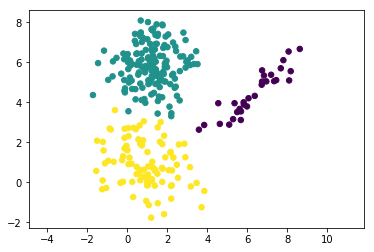

In [289]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and your token into variables below. You can generate the token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [ ]:
STUDENT_EMAIL = # EMAIL HERE
STUDENT_TOKEN = # TOKEN HERE
grader.status()

If you want to submit these answers, run cell below

In [ ]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)